# **GIS × Python Tutorial Session10 ~ DSMの作成とDCHMの作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事では DTM の後処理を行い、滑らかな DTM を作成しました。今回は DSM の作成と DCHM の作成を行います。

<br><br>

## **今回使用するデータ**
---
今回の記事では、オープンナガサキからダウンロードした点群データと前回の記事で作成した DTM を使用します。作成には `PDAL` と `rasterio` を使用しますので、このチュートリアルを初めて見た方は Session6 から読み進めて頂くとわかりやすいと思います。

https://zenn.dev/daidai_daitai/articles/4071f5aa17cd4b

conda 環境の設定ファイルや、この記事の作成に使用した Notebook は GitHub で公開しています。

https://github.com/shingo405nagano/WriteZenn

<br><br>



## **目次**
---
   
   1. DSM の作成

      1-1. DSM、DTM、DCHMとは

      1-2. 点群データの読み込みと DSM の作成

      1-3. DSM の可視化

   2. DCHM の作成

      2-1. rasterio での作成

      2-2. PDAL での作成

      2-3. DCHM の可視化

<br>

In [187]:
import json
from IPython.display import Image

import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import rasterio
japanize_matplotlib.japanize()

IN_FILE_LAS = r'../datasets/01ID7913_proj.las'
IN_FILE_DTM = r'../datasets/01ID7913_DTM_R05_SMOOTH.tif'
OUT_FILE_DSM = r'../datasets/01ID7913_DSM_R05.tif'
OUT_FILE_DCHM = r'../datasets/01ID7913_DCHM_R05.tif'

IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

<br>

## **1. DSM の作成**
---



<br>

### **1-1. DSM、DTM、DCHMとは**

 - **DTM**（Digital Terrain Model：数値地形モデル）
    ... DTM は地形の高さを表します。DEMと呼ばれる場合もあります。

 - **DSM**（Digital Surface Model：数値表層モデル）
    ... DSM は地形の高さと建物や樹木などの地物を含む高さを表します。

 - **DCHM**（Digital Canopy Height Model：数値樹冠高モデル）
    ... DCHM は純粋な地物の高さを表します。



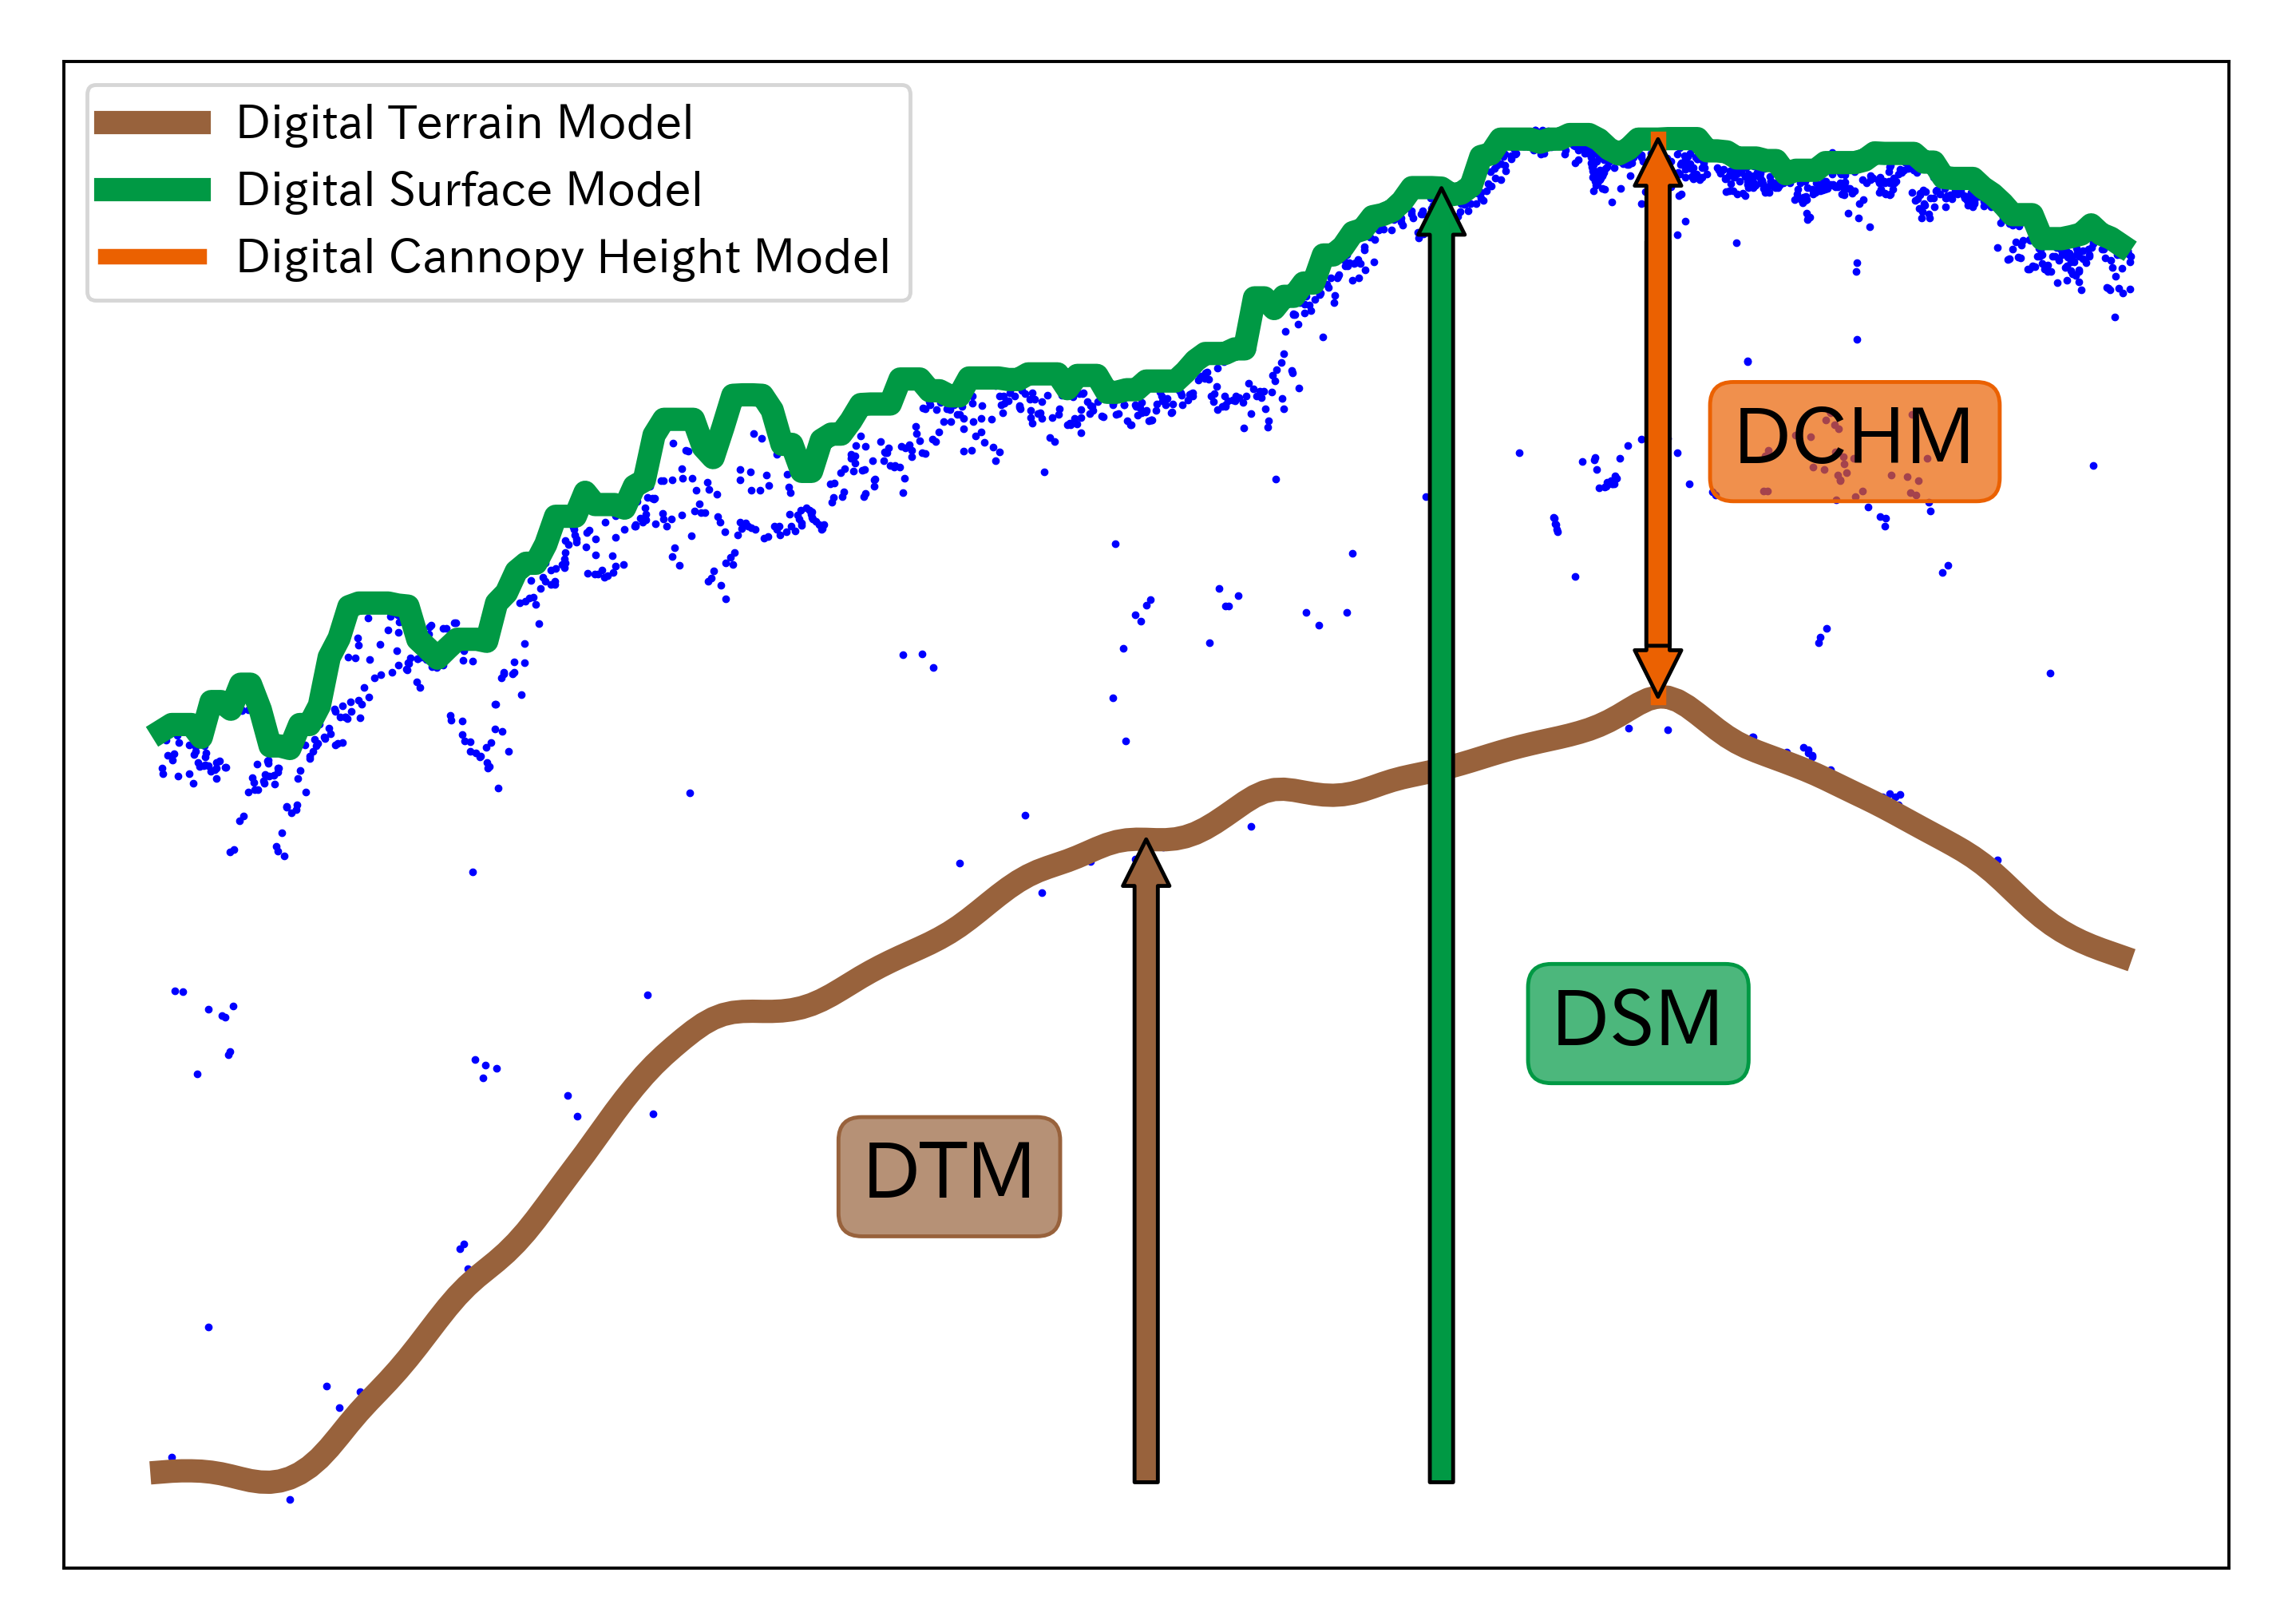

In [181]:
Image(r'../images/session10/raster_imgs.png',  width=800)

<br>

### **1-1. 点群データの読み込みとDSMの作成**
DSM の作成は非常に簡単です。以前の記事で DTM の出力を行った時と同じく PDAL を使用して点群データをグリッド事に抽出し、該当グリッド内の最も高い測点の高さを記録するだけです。

DTM を作成する場合は 'output_type' を 最小値に指定しましたが、今回は最大値に指定します。

In [185]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE_LAS
        },
        {
            'type': 'writers.gdal',
            'filename': OUT_FILE_DSM,
            'default_srs': IN_SRS,
            'resolution': 0.5,
            'radius': 1.0,
            'window_size': 4,
            'nodata': -9999,
            'output_type': 'max',
            'gdaldriver': 'GTiff'
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

6684581

<br>

### **1-3. DSMの可視化**
単純に可視化しただけでは、差が分かりづらかったので、等高線を追加して可視化範囲を絞り込んでいます。

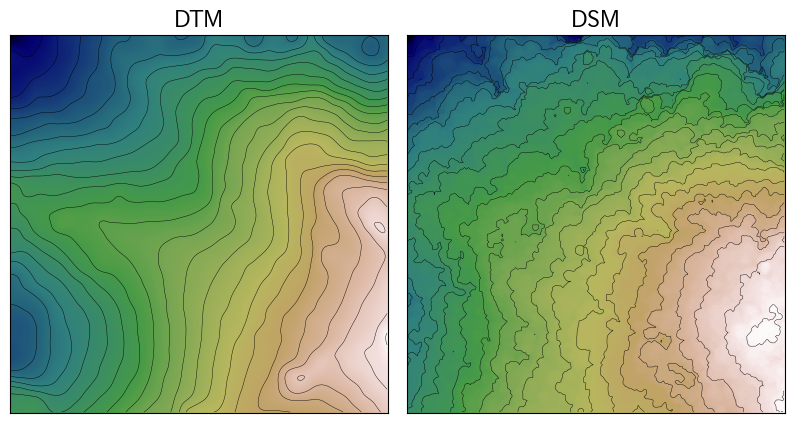

In [190]:
# Rasterの読み込み
with rasterio.open(IN_FILE_DTM, mode='r') as dst:
    dtm = dst.read(1)

with rasterio.open(OUT_FILE_DSM, mode='r') as dst:
    dsm = dst.read(1)

# 可視化
slice_ = slice(0, 200)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for _ax, title, img in zip(ax, ['DTM', 'DSM'], [dtm, dsm]):
    _img = img[slice_, slice_].copy()
    level = np.arange(_img.min(), _img.max(), 2)
    _ax.imshow(_img, cmap='gist_earth')
    _ax.contour(_img, levels=level, linewidths=0.3, colors='black')
    _ax.axes.yaxis.set_visible(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.set_title(title, fontsize=16)

plt.subplots_adjust(wspace=0.05)
# plt.savefig(r'../images/session10/dtm_dsm_img.png', dpi=300)
plt.show()

<br>

## **DCHMの作成**
---
DCHM の計算は簡単です。DSMを出力していて、地上分解能と範囲が同じならば、rasterio で DTM と DSM の両方を読み込み、配列として取得し差分を求めるだけです。

しかし場合によっては地上分解能が違ったり、範囲が微妙に違う場合があります。ここではまず DTM と DSM の差分を求める方法を紹介した後に、DTM と点群データから求める方法の 2種類を紹介します。


### 


Text(0.5, 1.0, 'DSMからDTMを引いたシンプルなDCHM')

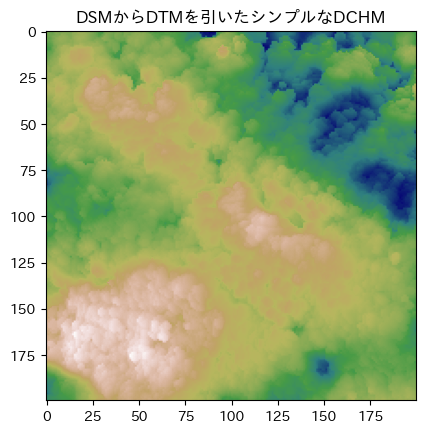

In [33]:
# DCHMの計算
dchm = dsm - dtm
plt.imshow(dchm[slice_, slice_], cmap='gist_earth');
plt.title('DSMからDTMを引いたシンプルなDCHM')

In [22]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE_LAS
        },
        {
            'type': 'filters.hag_dem',
            'raster': IN_FILE_DTM
        },
        {
            'type': 'filters.assign',
            'value': [
                'Z = HeightAboveGround'
            ]
        },
        {
            'type': 'writers.gdal',
            'filename': OUT_FILE_DCHM,
            'default_srs': IN_SRS,
            'resolution': 0.5,
            'radius': 1.0,
            'window_size': 4,
            'output_type': 'max',
            'gdaldriver': 'GTiff'
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

6684581

In [23]:
with rasterio.open(OUT_FILE_DCHM, mode='r') as dst:
    dchm_ = dst.read(1)

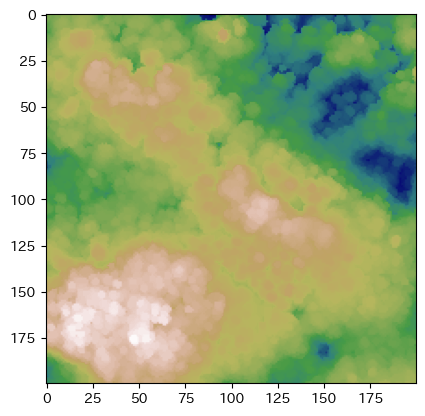

In [25]:
plt.imshow(dchm_[slice_, slice_], cmap='gist_earth')